# Google Colab 드라이브 mount

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [11]:
cd /content/drive/My Drive/데이터/강우예측AI 데이터

/content/drive/My Drive/데이터/강우예측AI 데이터


In [12]:
ls

Dacon_baseline_4.csv  sample_submission.csv  test.zip  train.zip


# Google Colab에서 zip 해제

파일 위치:

구글 드라이브 > 내 드라이브 > 강우예측 AI

In [13]:
import zipfile

In [14]:
cd /content

/content


In [15]:
ls

drive/  sample_data/


In [16]:
path = "/content/drive/My Drive/데이터/강우예측AI 데이터" # 절대경로로 압축해제할 파일위치 지정

In [17]:
# 압축해제된 파일은 content 즉, colab 상에 위치하므로 세션 초기화되면 삭제됨
# 압축해제 위치를 구글드라이브 강우예측 AI 폴더로 지정 가능

# 현재 디렉터리 ./ = /content 확인!
zip_file = zipfile.ZipFile(path + "/train.zip")
zip_file.extractall("/content") # 압축해제하여 현재 디렉토리에 저장. 내부의 train 폴더 자동 생성

zip_file2 = zipfile.ZipFile(path + "/test.zip")
zip_file2.extractall("/content/test/") # 압축해제하여 현재 디렉토리 아래 test 폴더에 저장

print("==================압축해제 완료==================")

==================압축해제 완료==================


## Training Data Preprocessing

In [18]:
import glob

# 정렬로 읽어들임
train_files = sorted(glob.glob("/content/train/*.npy"))
print(len(train_files)) # 62735

62735


In [19]:
# 정렬되었는지 확인
for i in range(10):
    print(train_files[i])

/content/train/train_00000.npy
/content/train/train_00001.npy
/content/train/train_00002.npy
/content/train/train_00003.npy
/content/train/train_00004.npy
/content/train/train_00005.npy
/content/train/train_00006.npy
/content/train/train_00007.npy
/content/train/train_00008.npy
/content/train/train_00009.npy


In [20]:
import numpy as np

train_files = np.array(train_files) # np.array로 변환
print(train_files.shape)

(62735,)


In [21]:
train_files[2]  # 개별 데이터는 .npy 확장자가 안풀린 상태. np.load로 읽어야 함

'/content/train/train_00002.npy'

In [22]:
# 내 방식으로 데이터 추출
train_x = []
train_y = []

for f in train_files:  # f로 각각의 데이터 읽어들임
    
    data = np.load(f)  # np.load로 f를 읽음
    label = data[:, :, -1].reshape(1, 120, 120, 1)  # 5장 중 마지막장은 라벨로 따로 처리
    remove_minus = np.where(label < 0, 0, label) # 라벨 이미지의 음수 부분을 0으로 처리
    feature = data[:, :, :4].reshape((4, 120, 120, 1)) # 4장의 이미지 input
        
    train_x.append(feature)
    train_y.append(remove_minus)

print("=================훈련데이터 추출 완료=================")

=================훈련데이터 추출 완료=================


In [23]:
# numpy array로 변환
train_x = np.array(train_x)
train_y = np.array(train_y)

print(train_x.shape) # 62735, 4, 120, 120, 1
print(train_y.shape) # 62735, 1, 120, 120, 1

(62735, 4, 120, 120, 1)
(62735, 1, 120, 120, 1)


## Test Data Preprocessing

In [24]:
# 정렬로 읽어들임
test_files = sorted(glob.glob("/content/test/*.npy"))
print(len(test_files)) # 2674

2674


In [25]:
test_files[2] # 개별 데이터는 .npy 확장자가 안풀린 상태??

for i in range(10):
    print(test_files[i])

/content/test/test_00000.npy
/content/test/test_00001.npy
/content/test/test_00002.npy
/content/test/test_00003.npy
/content/test/test_00004.npy
/content/test/test_00005.npy
/content/test/test_00006.npy
/content/test/test_00007.npy
/content/test/test_00008.npy
/content/test/test_00009.npy


In [26]:
# 내 방식으로 데이터 추출
test_x = []
test_y = []

for f in test_files:
    
    data = np.load(f)
    label = data[:, :, -1].reshape(1, 120, 120, 1)
    remove_minus = np.where(label < 0, 0, label)
    feature = data[:, :, :4].reshape(4, 120, 120, 1)
        
    test_x.append(feature) # 4장의 시계열 이미지
    test_y.append(remove_minus) # 음수는 0으로 처리된 5번째 이미지

print("================= 테스트 데이터 추출 완료=================")

================= 테스트 데이터 추출 완료=================


In [27]:
# np.array로 변환
test_x = np.array(test_x)
test_y = np.array(test_y)

# shape 확인
print(test_x.shape)
print(test_y.shape)

(2674, 4, 120, 120, 1)
(2674, 1, 120, 120, 1)


In [ ]:
#train_x = train_x / 255.0
#train_y = train_y / 255.0

## Library import

In [28]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-white")

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, concatenate, Input
from tensorflow.keras import Model

#
from sklearn.metrics import classification_report
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Input, Add, Conv2D, Conv3D, Concatenate, ConvLSTM2D, BatchNormalization, LeakyReLU, MaxPooling2D, UpSampling2D, TimeDistributed
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
#

import warnings
warnings.filterwarnings("ignore")

from keras.utils import plot_model

#
import os
import logging
logging.getLogger('tensorflow').setLevel(logging.DEBUG)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  ### NO WARNINGS!
print("[INFO] Imports loaded.")
#

[INFO] Imports loaded.


## Training data Visualization

In [29]:
# 시각화를 위한 컬러맵 속성 정의
color_map = plt.cm.get_cmap("RdBu")
color_map = color_map.reversed()

# train_files의 2번째 샘플을 예시로 시각화
image_sample = train_x[2]
image_sample = image_sample.reshape((120, 120, 4))
print(image_sample.shape)

image_target = train_y[2]
image_target = image_target.reshape((120, 120, 1))
print(image_target.shape)

(120, 120, 4)
(120, 120, 1)


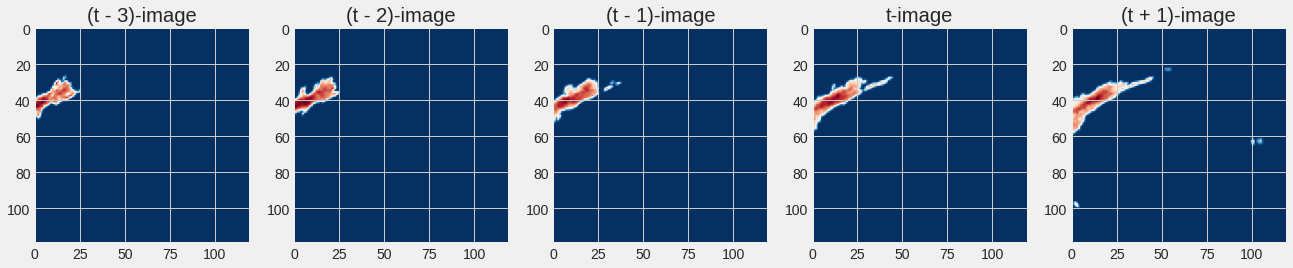

In [30]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (20, 20))

for i in range(4):
    
    if i == 3:
        plt.subplot(1, 5, i + 1)
        plt.title("t-image")
        plt.imshow(image_sample[:, :, i], cmap = color_map)
        
    else:
        plt.subplot(1, 5, i + 1)
        plt.title("(t - {})-image".format(4 - i - 1))
        plt.imshow(image_sample[:, :, i], cmap = color_map) # 4개의 기상관측 이미지(t-3, t-2, t-1, t)를 보여주고, (2차원 행렬)
    
plt.subplot(1, 5, 5)
plt.title("(t + 1)-image")
# reshape로 3차원 -> 2차원 변환
plt.imshow(image_target.reshape(120, 120), cmap = color_map)  # 1개의 그 다음 기상관측 이미지(t+1)를 추측해야 함
plt.show()

## BASELINE Modeling

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 4, 120, 120, 1)]  0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 4, 120, 120, 128)  3328      
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 2, 120, 120, 128)  0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 2, 120, 120, 128)  409728    
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 1, 120, 120, 128)  0         
_________________________________________________________________
conv_lst_m2d_9 (ConvLSTM2D)  (None, 1, 120, 120, 64)   442624    
_________________________________________________________________
outputs (Conv3D)             (None, 1, 120, 120, 1)    1729

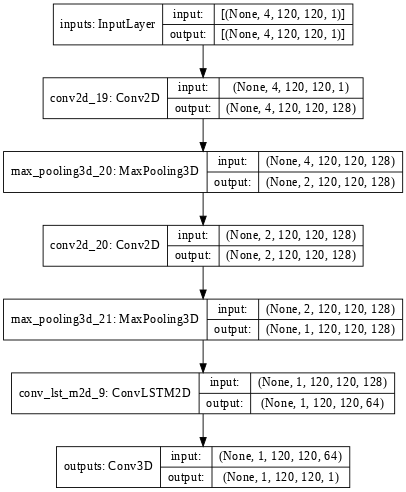

In [52]:
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
## NEW NETWORK ##

def build_model():

    inputs = Input(shape = (4, 120, 120, 1), name = 'inputs', dtype = 'float32')
    x = Conv2D(128, (5, 5), padding = 'same', activation = 'relu')(inputs)
    x = MaxPooling3D((2, 1, 1))(x)
    x = Conv2D(128, (5, 5), padding = 'same', activation = 'relu')(x)
    x = MaxPooling3D((2, 1, 1))(x)

    x = ConvLSTM2D(64, (3, 3), padding = 'same', return_sequences = True, kernel_initializer = 'he_normal')(x)
    #x = MaxPooling3D((4, 1, 1))(x)

    outputs = Conv3D(1, 3, activation='relu', padding='same',  name='outputs')(x) #sigmoid original

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = build_model()
model.summary()
plot_model(model, show_shapes = True, dpi = 64)

In [53]:
# 학습 방식 결정
model.compile(loss = 'mae',
             optimizer = 'adam',
             metrics = ['mse'])

In [54]:
# 이 부분에서 콜백 함수에 넣을 콜백리스트 정의할 것!
import keras

callbacks_list = [
    # 조기종료 콜백함수 : val loss 감시, 10에폭까지 기다림
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7),
    
    # 모델 체크포인트 콜백함수 : 모델을 h5로 저장, 최적 모델만을 저장
    keras.callbacks.ModelCheckpoint(filepath = "Best_Model.h5", monitor = 'val_loss', save_best_only = True),
    
    # 학습률 감소 콜백함수 : val loss 감시, 검증 손실 향상안될때 10분의 1감소시킴
    keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3)
]


In [ ]:
%%time 
# hist객체에 fit history 저장
hist = model.fit(train_x, train_y,
                 epochs = 5, 
                 batch_size = 64,  
                 callbacks = callbacks_list,
                 validation_split = 0.2,
                 verbose = 1)    
  

Epoch 1/5
399/785 [==============>...............] - ETA: 11:27 - loss: 13.9317 - mse: 1574.2179

In [ ]:
for key in hist.history:
    print(key)

loss
mse
val_loss
val_mse
lr


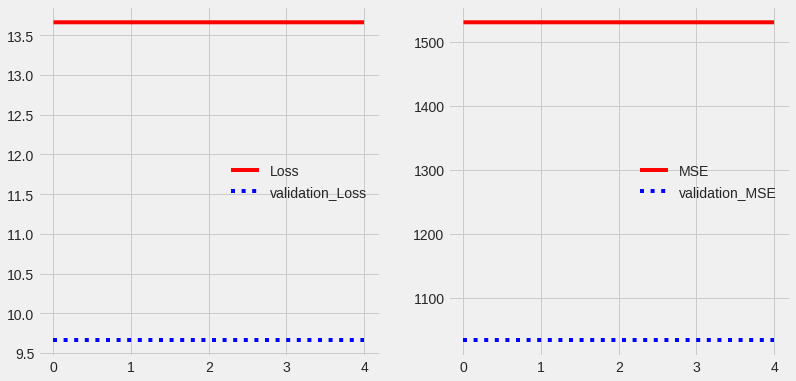

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
mse = hist.history['mse']
val_mse = hist.history['val_mse']
lr = hist.history['lr']

plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(loss, 'r-', label = 'Loss')
plt.plot(val_loss, "b:", label = 'validation_Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mse, 'r-', label = 'MSE')
plt.plot(val_mse, "b:", label = 'validation_MSE')
plt.legend()

plt.show()

# TEST

In [ ]:
test_x = test_x.astype('float32') / 255.0
test_y = test_y.astype('float32') / 255.0

print(test_x.shape)
print(test_y.shape)



(2674, 4, 120, 120, 1)
(2674, 1, 120, 120, 1)


In [ ]:
predict = model.predict(test_x)
print(predict.shape)

(2674, 1, 120, 120, 1)


In [ ]:
test_y[2].shape

(1, 120, 120, 1)

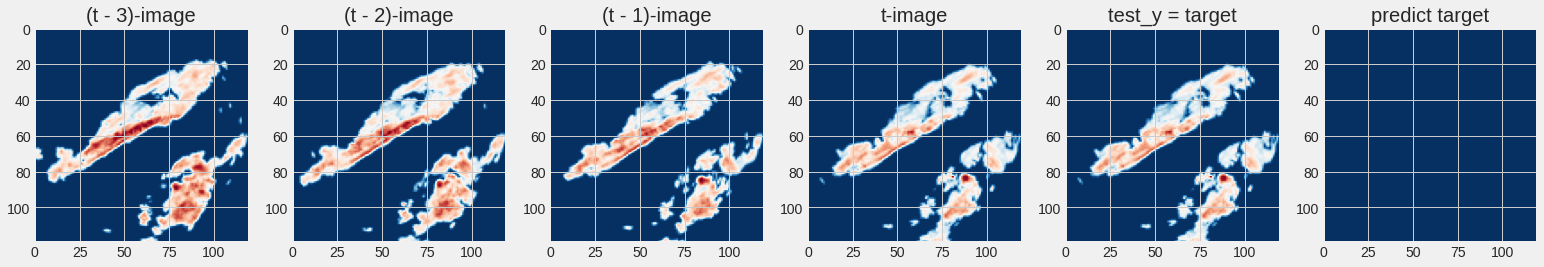

In [ ]:
# 시각화를 위한 컬러맵 속성 정의
color_map = plt.cm.get_cmap("RdBu")
color_map = color_map.reversed()

plt.style.use('fivethirtyeight')
plt.figure(figsize = (24, 20))

for j in range(10):  # 10개의 test 데이터에 대한 시각화 확인 작업

    image_sample = test_x[j]
    image_target = test_y[j]
    #predicted_target = predict[j]
    
    # 4개의 test_x 데이터를 보여주고
    for i in range(4):
        
        if i == 3:
            plt.subplot(1, 6, i + 1)
            plt.title("t-image")
            plt.imshow(image_sample.reshape((120, 120, 4))[:, :, i], cmap = color_map)
        
        else:
            plt.subplot(1, 6, i + 1)
            plt.title("(t - {})-image".format(4 - i - 1))
            plt.imshow(image_sample.reshape((120, 120, 4))[:, :, i], cmap = color_map) # 4개의 기상관측 이미지(t-3, t-2, t-1, t)를 보여주고, (2차원 행렬)


    # 1개의 test_y(=target) 데이터 시각화하고
    plt.subplot(1, 6, 5)
    plt.title("test_y = target")
    plt.imshow(image_target.reshape((120, 120)), cmap = color_map)  # 1개의 그 다음 기상관측 이미지(t+1)를 추측해야 함
    
    
    # 1개의 predict(예측) 데이터 시각화한다.
    plt.subplot(1, 6, 6)
    plt.title("predict target")
    plt.imshow(predict[j].reshape((120, 120)), cmap = color_map)
    
    
plt.show()

In [ ]:
# submission.csv 파일을 읽어온다
submission = pd.read_csv("/content/drive/My Drive/강우예측AI/sample_submission.csv")


In [ ]:
# predict결과를 적절히 reshape하여 submission.csv에 저장
submission.iloc[:, 1:] = predict.reshape(-1, 14400).astype(int)
submission.to_csv(path + "/Dacon_baseline_4.csv", index = False)

In [ ]:
ls

Best_Model.h5  drive/  model.png  sample_data/  test/  train/
